In [2]:
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import os

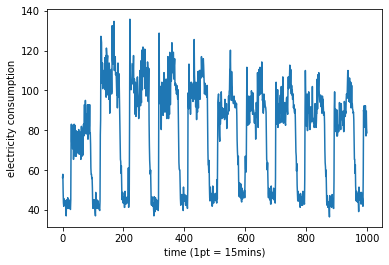

In [3]:
import matplotlib.pyplot as plt

data = np.load("LD_250.npy")

NUM_ENTRIES = 1000
plt.plot(range(NUM_ENTRIES), data[0:NUM_ENTRIES])
plt.ylabel("electricity consumption")
plt.xlabel("time (1pt = 15mins)")
plt.show()

In [80]:
print(len(data))
print(len(data[0:1000]))

140256
1000


In [4]:
NUM_TIMESTEPS = 20


X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i+NUM_TIMESTEPS].T  # i+NUM_TIMESTEPS は exclusiveなので
    Y[i] = data[i+NUM_TIMESTEPS+1]    # ここでは30分後の消費量を予測することになる

# reshape X to 3 dimensions (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

140235


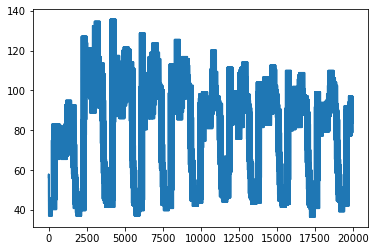

In [5]:
print(len(data) - NUM_TIMESTEPS - 1)
import matplotlib.pyplot as plt
plt.plot(X[0:1000].reshape(-1,1))

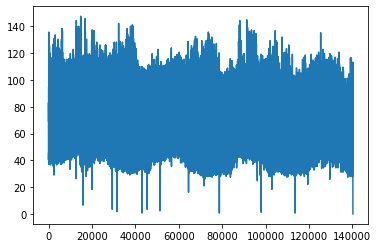

In [6]:
import matplotlib.pyplot as plt
plt.plot(Y)

In [7]:
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(98179, 20, 1) (42077, 20, 1) (98179, 1) (42077, 1)


In [8]:
def stateless_network(hidden_size, input_shape):
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=input_shape, return_sequences=False))
    model.add(Dense(1))
    return model

def stateful_network(hidden_size, input_shape):
    model = Sequential()
    model.add(LSTM(hidden_size,
                   stateful=True,
                   batch_input_shape=input_shape,
                   return_sequences=False))
    model.add(Dense(1))
    return model

In [9]:
HIDDEN_SIZE = 10
BATCH_SIZE = 24 * 4  # data num of 24 hours (per 15 min)

model = stateless_network(hidden_size=HIDDEN_SIZE,
                          input_shape=(NUM_TIMESTEPS, 1))

model2 = stateful_network(hidden_size=HIDDEN_SIZE,
                        input_shape=(BATCH_SIZE, NUM_TIMESTEPS, 1))

In [10]:
model.compile(loss="mean_squared_error",
             optimizer="adam",
             metrics=["mean_squared_error"])

model2.compile(loss="mean_squared_error",
             optimizer="adam",
             metrics=["mean_squared_error"])

In [11]:
NUM_EPOCHS = 5

model.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
          validation_data=(Xtest, Ytest),
          shuffle=False)

Epoch 1/5
1023/1023 [==============================] - 14s 11ms/step - loss: 6478.1430 - mean_squared_error: 6478.1430 - val_loss: 4298.3179 - val_mean_squared_error: 4298.3179
Epoch 2/5
1023/1023 [==============================] - 10s 10ms/step - loss: 4863.8966 - mean_squared_error: 4863.8966 - val_loss: 3273.7681 - val_mean_squared_error: 3273.7681
Epoch 3/5
1023/1023 [==============================] - 12s 12ms/step - loss: 3791.7860 - mean_squared_error: 3791.7860 - val_loss: 2470.5603 - val_mean_squared_error: 2470.5603
Epoch 4/5
1023/1023 [==============================] - 12s 12ms/step - loss: 2898.2299 - mean_squared_error: 2898.2299 - val_loss: 1699.9172 - val_mean_squared_error: 1699.9172
Epoch 5/5
1023/1023 [==============================] - 13s 12ms/step - loss: 2057.1621 - mean_squared_error: 2057.1621 - val_loss: 1186.3774 - val_mean_squared_error: 1186.3774


In [12]:
score, _ = model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
rmse = math.sqrt(score)
print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))

439/439 [==============================] - 1s 3ms/step - loss: 1186.3774 - mean_squared_error: 1186.3774

MSE: 1186.377, RMSE: 34.444


[[56.29075361]
 [57.89951897]
 [48.80277926]
 ...
 [93.92838055]
 [93.393907  ]
 [91.25066809]]


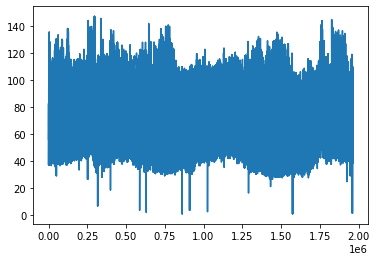

In [13]:
import matplotlib.pyplot as plt
print(Xtrain.reshape(-1,1))
plt.plot(Xtrain.reshape(-1,1))

[[47.87014 ]
 [47.87013 ]
 [47.870144]
 ...
 [15.752567]
 [15.752567]
 [15.752567]]


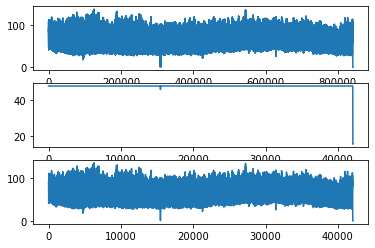

In [43]:
tmp = model.predict(Xtest,batch_size=BATCH_SIZE)

print(tmp)

import matplotlib.pyplot as plt

plt.figure()
plt.subplot(311)
plt.plot(Xtest.reshape(-1,1))
plt.subplot(312)
plt.plot(tmp)
plt.subplot(313)
plt.plot(Ytest)